## Gerry Chain

In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import cut_edges
from gerrychain.metrics import efficiency_gap
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar
import pandas as pd

In [2]:
import pandas as pd

# Read your shapefile
df = gpd.read_file("./VA/VA.shp")

# List all population columns from your dataset
population_columns = [
    'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 
    'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 
    'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'
]

# Replace NaN values with 0 in all population columns
for col in population_columns:
    df[col] = df[col].fillna(0)

In [3]:
graph = Graph.from_geodataframe(df,adjacency="rook")

/Users/chaoping/miniconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column G18USSD!
  warnings.warn("NA values found in column {}!".format(column))
/Users/chaoping/miniconda3/envs/gerry/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column G18USSR!
  warnings.warn("NA values found in column {}!".format(column))


In [4]:
elections = [
    Election("PRE20", {"Democratic": "G20PRED", "Republican": "G20PRER"}),
    Election("SEN20", {"Democratic": "G20USSD", "Republican": "G20USSR"})  
             ]

In [5]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges
}

In [6]:
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [7]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "SEND", 
                                        updaters=my_updaters)

In [8]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [9]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.1,
                   node_repeats=2
                  )

In [10]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [11]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.1)

In [12]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=500
    )

# Evidence of Convergence for PRE20 election

In [13]:
# Run the Markov Chain with 40,000 steps
long_chain = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=40000
)

In [14]:
# initial lists
efficiency_gaps_long = []
dem_won_districts_long = []
pre20_vote_shares = []

for i, partition in enumerate(long_chain.with_progress_bar()):
    eg = partition["PRE20"].efficiency_gap()
    efficiency_gaps_long.append(eg)

    dem_wins = 0

    # Iterate through each district
    for district in partition.parts:
        nodes_in_district = [n for n, part in partition.assignment.items() if part == district]

        # Aggregate votes for this district
        dem_total = sum(partition.graph.nodes[n]["G20PRED"] for n in nodes_in_district)
        rep_total = sum(partition.graph.nodes[n]["G20PRER"] for n in nodes_in_district)

        if dem_total > rep_total:
            dem_wins += 1

    dem_won_districts_long.append(dem_wins)

    # Collect PRE20 Dem vote shares (for marginal boxplot), only after burn-in
    if i >= 20000:
        pre20_vote_shares.append(sorted(partition["PRE20"].percents("Democratic")))

/Users/chaoping/miniconda3/envs/gerry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████| 40000/40000 [06:24<00:00, 104.01it/s]


In [15]:
# Convergence check: Split into halves 
first_half_eg = efficiency_gaps_long[:20000]
second_half_eg = efficiency_gaps_long[20000:]
first_half_dem = dem_won_districts_long[:20000]
second_half_dem = dem_won_districts_long[20000:]

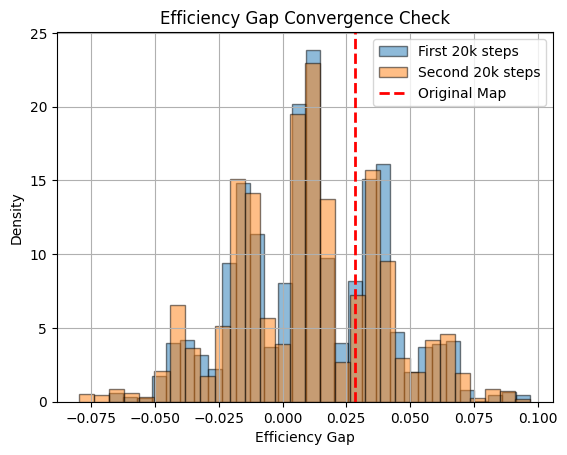

In [16]:
# Efficiency Gap Convergence Plot
original_eg = partition["PRE20"].efficiency_gap()  

plt.hist(first_half_eg, bins=30, alpha=0.5, label="First 20k steps", density=True, edgecolor='black')
plt.hist(second_half_eg, bins=30, alpha=0.5, label="Second 20k steps", density=True, edgecolor='black')
plt.axvline(original_eg, color='red', linestyle='--', linewidth=2, label='Original Map')
plt.title("Efficiency Gap Convergence Check")
plt.xlabel("Efficiency Gap")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
original_dem_wins = 0
for district in initial_partition.parts:
    nodes_in_district = [n for n, part in initial_partition.assignment.items() if part == district]
    dem_total = sum(initial_partition.graph.nodes[n]["G20PRED"] for n in nodes_in_district)
    rep_total = sum(initial_partition.graph.nodes[n]["G20PRER"] for n in nodes_in_district)
    if dem_total > rep_total:
        original_dem_wins += 1

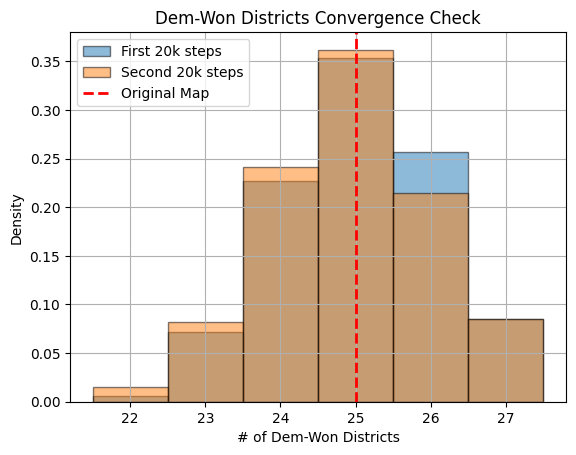

In [18]:
# Dem-Won Districts Convergence Plot
plt.hist(first_half_dem, bins=range(min(dem_won_districts_long), max(dem_won_districts_long)+1), 
         alpha=0.5, label="First 20k steps", density=True, align='left', edgecolor='black')
plt.hist(second_half_dem, bins=range(min(dem_won_districts_long), max(dem_won_districts_long)+1), 
         alpha=0.5, label="Second 20k steps", density=True, align='left', edgecolor='black')
plt.axvline(original_dem_wins, color='red', linestyle='--', linewidth=2, label='Original Map')
plt.title("Dem-Won Districts Convergence Check")
plt.xlabel("# of Dem-Won Districts")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Convert to DataFrame for boxplot
data = pd.DataFrame(pre20_vote_shares)

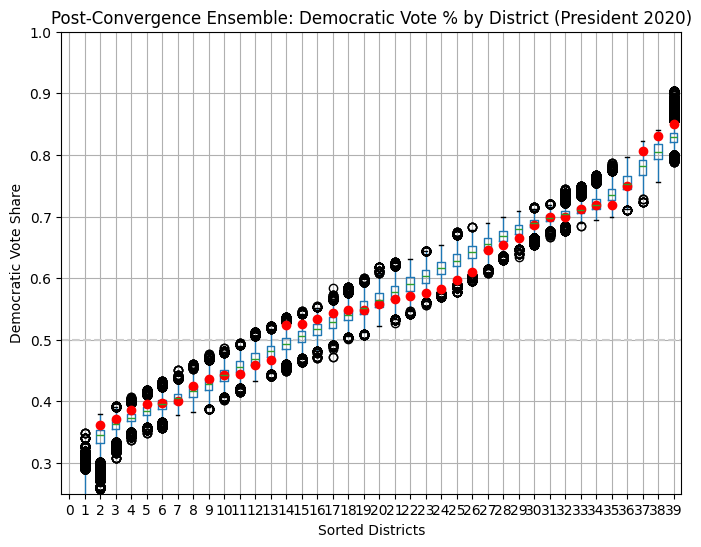

In [20]:
# Plot marginal boxplot of PRE20 vote share
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(0.5, color="#cccccc", linestyle='--')  # 50% threshold
data.boxplot(ax=ax, positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")  # First post-burn-in plan
ax.set_title("Post-Convergence Ensemble: Democratic Vote % by District (President 2020)")
ax.set_ylabel("Democratic Vote Share")
ax.set_xlabel("Sorted Districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.grid(True)
plt.show()

# Evidence of Convergence for SEN20 election

In [21]:
# initial lists
efficiency_gaps_long = []
dem_won_districts_long = []
sen20_vote_shares = []

for i, partition in enumerate(long_chain.with_progress_bar()):
    eg = partition["SEN20"].efficiency_gap()
    efficiency_gaps_long.append(eg)

    dem_wins = 0

    # Iterate through each district
    for district in partition.parts:
        nodes_in_district = [n for n, part in partition.assignment.items() if part == district]

        # Aggregate votes for this district
        dem_total = sum(partition.graph.nodes[n]["G20USSD"] for n in nodes_in_district)
        rep_total = sum(partition.graph.nodes[n]["G20USSR"] for n in nodes_in_district)

        if dem_total > rep_total:
            dem_wins += 1

    dem_won_districts_long.append(dem_wins)

    # Collect SEN20 Dem vote shares (for marginal boxplot), only after burn-in
    if i >= 20000:
        sen20_vote_shares.append(sorted(partition["SEN20"].percents("Democratic")))

100%|████████████████████████████████████| 40000/40000 [06:26<00:00, 103.60it/s]


In [22]:
# Convergence check: Split into halves 
first_half_eg = efficiency_gaps_long[:20000]
second_half_eg = efficiency_gaps_long[20000:]
first_half_dem = dem_won_districts_long[:20000]
second_half_dem = dem_won_districts_long[20000:]

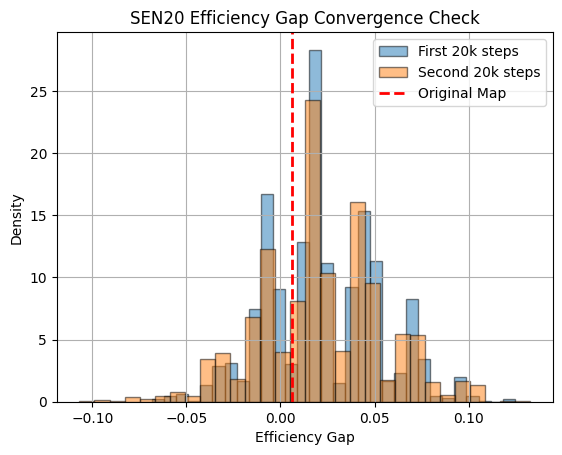

In [23]:
# Efficiency Gap Convergence Plot
original_eg = partition["SEN20"].efficiency_gap()  

plt.hist(first_half_eg, bins=30, alpha=0.5, label="First 20k steps", density=True, edgecolor='black')
plt.hist(second_half_eg, bins=30, alpha=0.5, label="Second 20k steps", density=True, edgecolor='black')
plt.axvline(original_eg, color='red', linestyle='--', linewidth=2, label='Original Map')
plt.title("SEN20 Efficiency Gap Convergence Check")
plt.xlabel("Efficiency Gap")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
original_dem_wins_sen20 = 0
for district in initial_partition.parts:
    nodes_in_district = [n for n, part in initial_partition.assignment.items() if part == district]
    dem_total = sum(initial_partition.graph.nodes[n]["G20USSD"] for n in nodes_in_district)
    rep_total = sum(initial_partition.graph.nodes[n]["G20USSR"] for n in nodes_in_district)
    if dem_total > rep_total:
        original_dem_wins_sen20 += 1

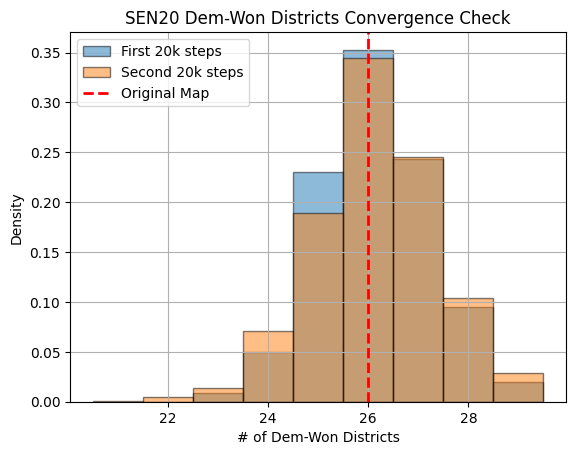

In [25]:
# Dem-Won Districts Convergence Plot
plt.hist(first_half_dem, bins=range(min(dem_won_districts_long), max(dem_won_districts_long)+1), 
         alpha=0.5, label="First 20k steps", density=True, align='left', edgecolor='black')
plt.hist(second_half_dem, bins=range(min(dem_won_districts_long), max(dem_won_districts_long)+1), 
         alpha=0.5, label="Second 20k steps", density=True, align='left', edgecolor='black')
plt.axvline(original_dem_wins_sen20, color='red', linestyle='--', linewidth=2, label='Original Map')
plt.title("SEN20 Dem-Won Districts Convergence Check")
plt.xlabel("# of Dem-Won Districts")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Convert to DataFrame for boxplot
data = pd.DataFrame(sen20_vote_shares)

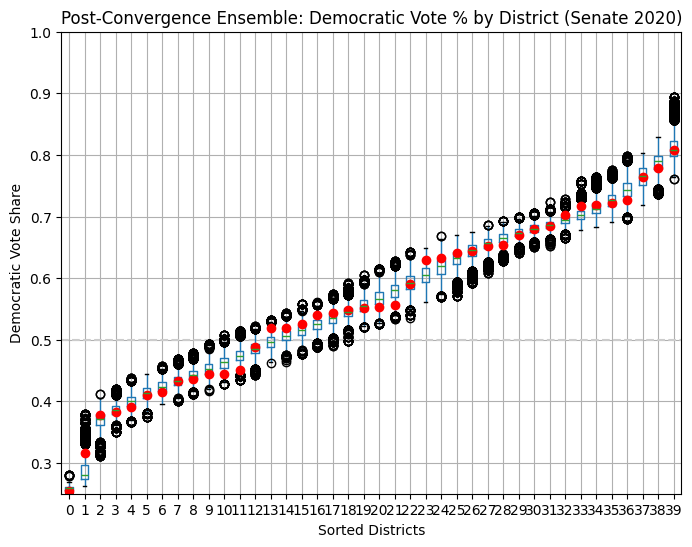

In [27]:
# Plot marginal boxplot of PRE20 vote share
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(0.5, color="#cccccc", linestyle='--')  # 50% threshold
data.boxplot(ax=ax, positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")  # First post-burn-in plan
ax.set_title("Post-Convergence Ensemble: Democratic Vote % by District (Senate 2020)")
ax.set_ylabel("Democratic Vote Share")
ax.set_xlabel("Sorted Districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.grid(True)
plt.show()